In [1]:
import warnings
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import datetime
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
sys.path.append("C:/dev/pycmqlib3/")
sys.path.append("C:/dev/pycmqlib3/misc_scripts/")
warnings.filterwarnings('ignore')
import misc
import data_handler as dh
import plotly_examples
import backtest
import alphalens as al
%matplotlib inline

In [2]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'ZC', 'SM', "SF"]
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu'] #, 'sc', 'fu', 'eg']
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd']#, 'AP', 'sp']
ags_all_mkts = ags_oil_mkts + ags_soft_mkts
eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF']
fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts


In [8]:
field_list = ['open', 'high', 'low', 'close', 'volume', 'openInterest', 'contract', 'shift', 'atr']

start_date = datetime.date(2015,11,1)
end_date = datetime.date(2020,6,29)

sim_products = ['rb', 'hc', 'i', 'j', 'jm', 'ru', 'FG', 'ZC', \
                'cu', 'al', 'zn', 'pb', 'ni', 'sn', \
                'l', 'pp', 'v', 'TA', 'MA', 'bu', \
                'm', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', \
                'CF', 'SR', 'jd']
need_shift = 2
freq = 'd'

args = {'n': 1, 'roll_rule': '-35b', 'freq': freq, 'need_shift': need_shift}
ferrous_products_args = args
ferro_mixed_mkt_args = args
base_args = {'n': 1, 'roll_rule': '-35b', 'freq': freq, 'need_shift': need_shift}
eq_args = {'n': 1, 'roll_rule': '-1b', 'freq': freq, 'need_shift': need_shift}
bond_args = {'n': 1, 'roll_rule': '-30b', 'freq': freq, 'need_shift': need_shift}
precious_args = {'n': 1, 'roll_rule': '-25b', 'freq': freq, 'need_shift': need_shift}

atr_win = 20
df_list = []
for idx, asset in enumerate(sim_products):
    use_args = args
    if asset in eq_fut_mkts:
        use_args = eq_args
    elif asset in ['cu', 'al', 'zn', 'pb', 'sn']:
        use_args = base_args
    elif asset in bond_fut_mkts:
        use_args = bond_args
    elif asset in precious_metal_mkts:
        use_args = precious_args
    use_args['start_date'] = max(backtest.sim_start_dict[asset], start_date)
    use_args['end_date'] = end_date
    print("loading mkt = %s, args = %s" % (asset, use_args))
    df = misc.nearby(asset, **use_args)
    if freq == 'm':
        df = misc.cleanup_mindata(df, asset)
    if (idx == 0) and (freq == 'm'):
        df_list.append(df[['date', 'min_id']])
    df['atr'] = dh.ATR(df, atr_win)
    xdf = df[field_list]
    xdf.columns = [(asset, col) for col in xdf.columns]
    df_list.append(xdf)

df = pd.concat(df_list, axis = 1, sort = False).fillna(method = 'ffill')

loading mkt = rb, args = {'n': 1, 'roll_rule': '-35b', 'freq': 'd', 'need_shift': 2, 'start_date': datetime.date(2015, 11, 1), 'end_date': datetime.date(2020, 6, 29)}
loading mkt = hc, args = {'n': 1, 'roll_rule': '-35b', 'freq': 'd', 'need_shift': 2, 'start_date': datetime.date(2015, 11, 1), 'end_date': datetime.date(2020, 6, 29)}
loading mkt = i, args = {'n': 1, 'roll_rule': '-35b', 'freq': 'd', 'need_shift': 2, 'start_date': datetime.date(2015, 11, 1), 'end_date': datetime.date(2020, 6, 29)}
loading mkt = j, args = {'n': 1, 'roll_rule': '-35b', 'freq': 'd', 'need_shift': 2, 'start_date': datetime.date(2015, 11, 1), 'end_date': datetime.date(2020, 6, 29)}
loading mkt = jm, args = {'n': 1, 'roll_rule': '-35b', 'freq': 'd', 'need_shift': 2, 'start_date': datetime.date(2015, 11, 1), 'end_date': datetime.date(2020, 6, 29)}
loading mkt = ru, args = {'n': 1, 'roll_rule': '-35b', 'freq': 'd', 'need_shift': 2, 'start_date': datetime.date(2015, 11, 1), 'end_date': datetime.date(2020, 6, 29)}


In [9]:
df.index = pd.to_datetime(df.index)
df.index.names = ['date']
df.columns = pd.MultiIndex.from_tuples(df.columns, names = ['asset', 'feild'])

xdf = df.copy()
win = 120
ma_win = 1
factor_name = 'ret_fact'
price_field = 'close'
for asset in sim_products:
    if need_shift == 1:
        xdf[(asset, 'lr')] = ((xdf[(asset, 'close')]- xdf[(asset, 'shift')]).astype('float')\
                                /(xdf[(asset, 'close')].shift(1) - xdf[(asset, 'shift')]) - 1.0) * 100.0
    else:
        xdf[(asset, 'lr')] = (xdf[(asset, 'close')].astype('float')\
                              / xdf[(asset, 'close')].shift(1) - 1.0) * 100.0
    xdf[(asset, factor_name)] = xdf[(asset, 'lr')].rolling(win).sum().rolling(ma_win).mean()
fac_df = xdf[[(asset, factor_name) for asset in sim_products]]
fac_df.columns = sim_products
fac_ts = fac_df.stack()
fac_ts.name = factor_name
pricing_data = xdf[[(asset, price_field) for asset in sim_products]].astype('float')
pricing_data.columns = sim_products
factor_data = al.utils.get_clean_factor_and_forward_returns(fac_ts, pricing_data, quantiles=10, periods=(1,5,10))
print(factor_data.head())


Dropped 1.0% entries from factor data: 1.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
                        1D        5D       10D     factor  factor_quantile
date       asset                                                          
2016-04-27 rb     0.015194 -0.076769 -0.170332  41.846177                9
           hc     0.023176 -0.066869 -0.150456  44.370693               10
           i      0.025316 -0.050633 -0.141542  39.685323                9
           j     -0.000473 -0.028382 -0.135289  50.215877               10
           jm    -0.042022 -0.072226 -0.101116  44.852251               10


Information Analysis


,1D,5D,10D
IC Mean,0.013,0.021,0.023
IC Std.,0.303,0.289,0.268
Risk-Adjusted IC,0.043,0.072,0.087
t-stat(IC),1.361,2.291,2.766
p-value(IC),0.174,0.022,0.006
IC Skew,-0.116,-0.189,-0.292
IC Kurtosis,-0.401,-0.330,-0.125


<Figure size 432x288 with 0 Axes>

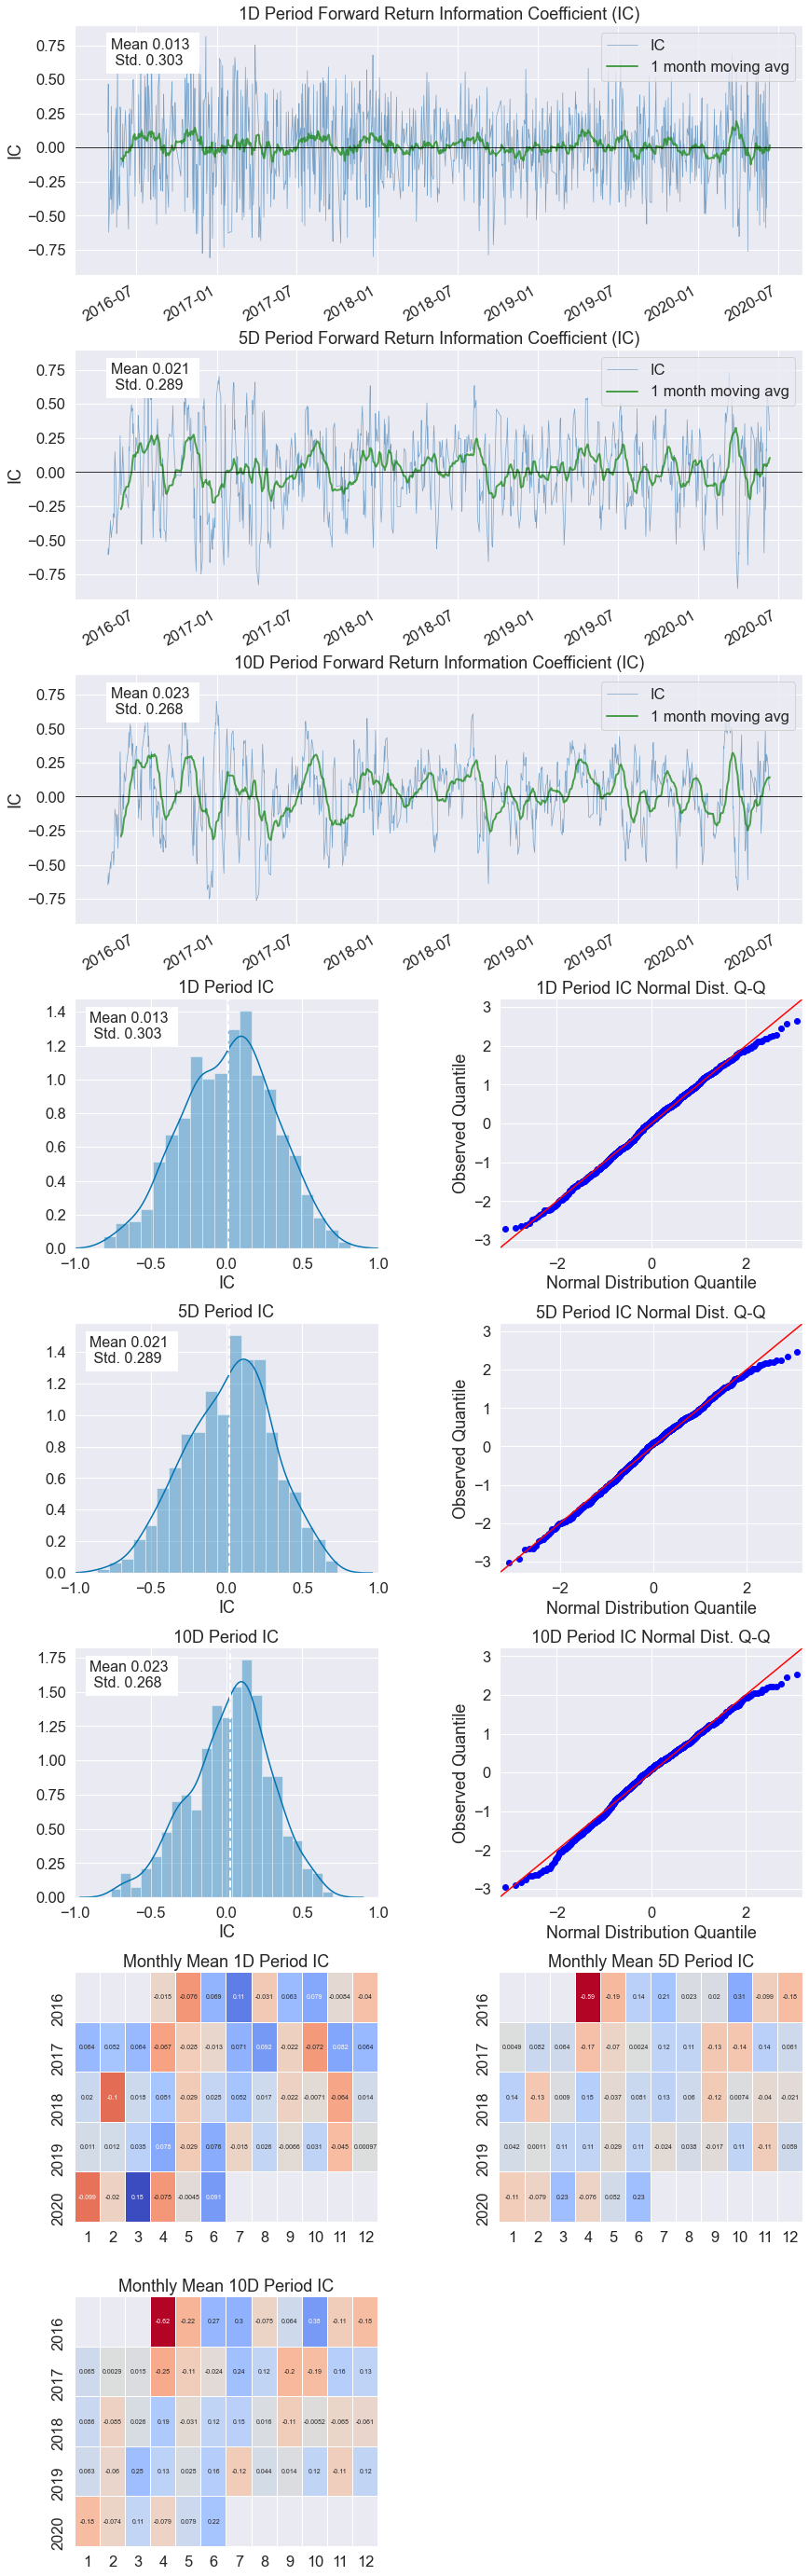

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-54.552897,8.045759,-13.467045,10.017636,3999,12.844479
2,-32.544030,13.316560,-6.302642,7.263493,3015,9.683947
3,-23.323049,17.766116,-2.964431,6.799921,3015,9.683947
4,-21.824372,25.257927,-0.177305,7.101193,3015,9.683947
5,-18.293370,27.949925,2.783439,7.940262,3015,9.683947
6,-11.090270,34.425473,5.753872,8.697160,3015,9.683947
7,-8.374355,41.296755,8.885437,9.575791,3015,9.683947
8,-6.674699,48.966868,12.638105,10.764020,3015,9.683947
9,-4.050087,60.247202,17.754937,12.147582,3015,9.683947


Returns Analysis


,1D,5D,10D
Ann. alpha,0.032,0.032,0.030
beta,0.259,0.273,0.281
Mean Period Wise Return Top Quantile (bps),6.525,4.887,5.396
Mean Period Wise Return Bottom Quantile (bps),-1.645,-1.839,-2.021
Mean Period Wise Spread (bps),8.170,6.321,6.963


<Figure size 432x288 with 0 Axes>

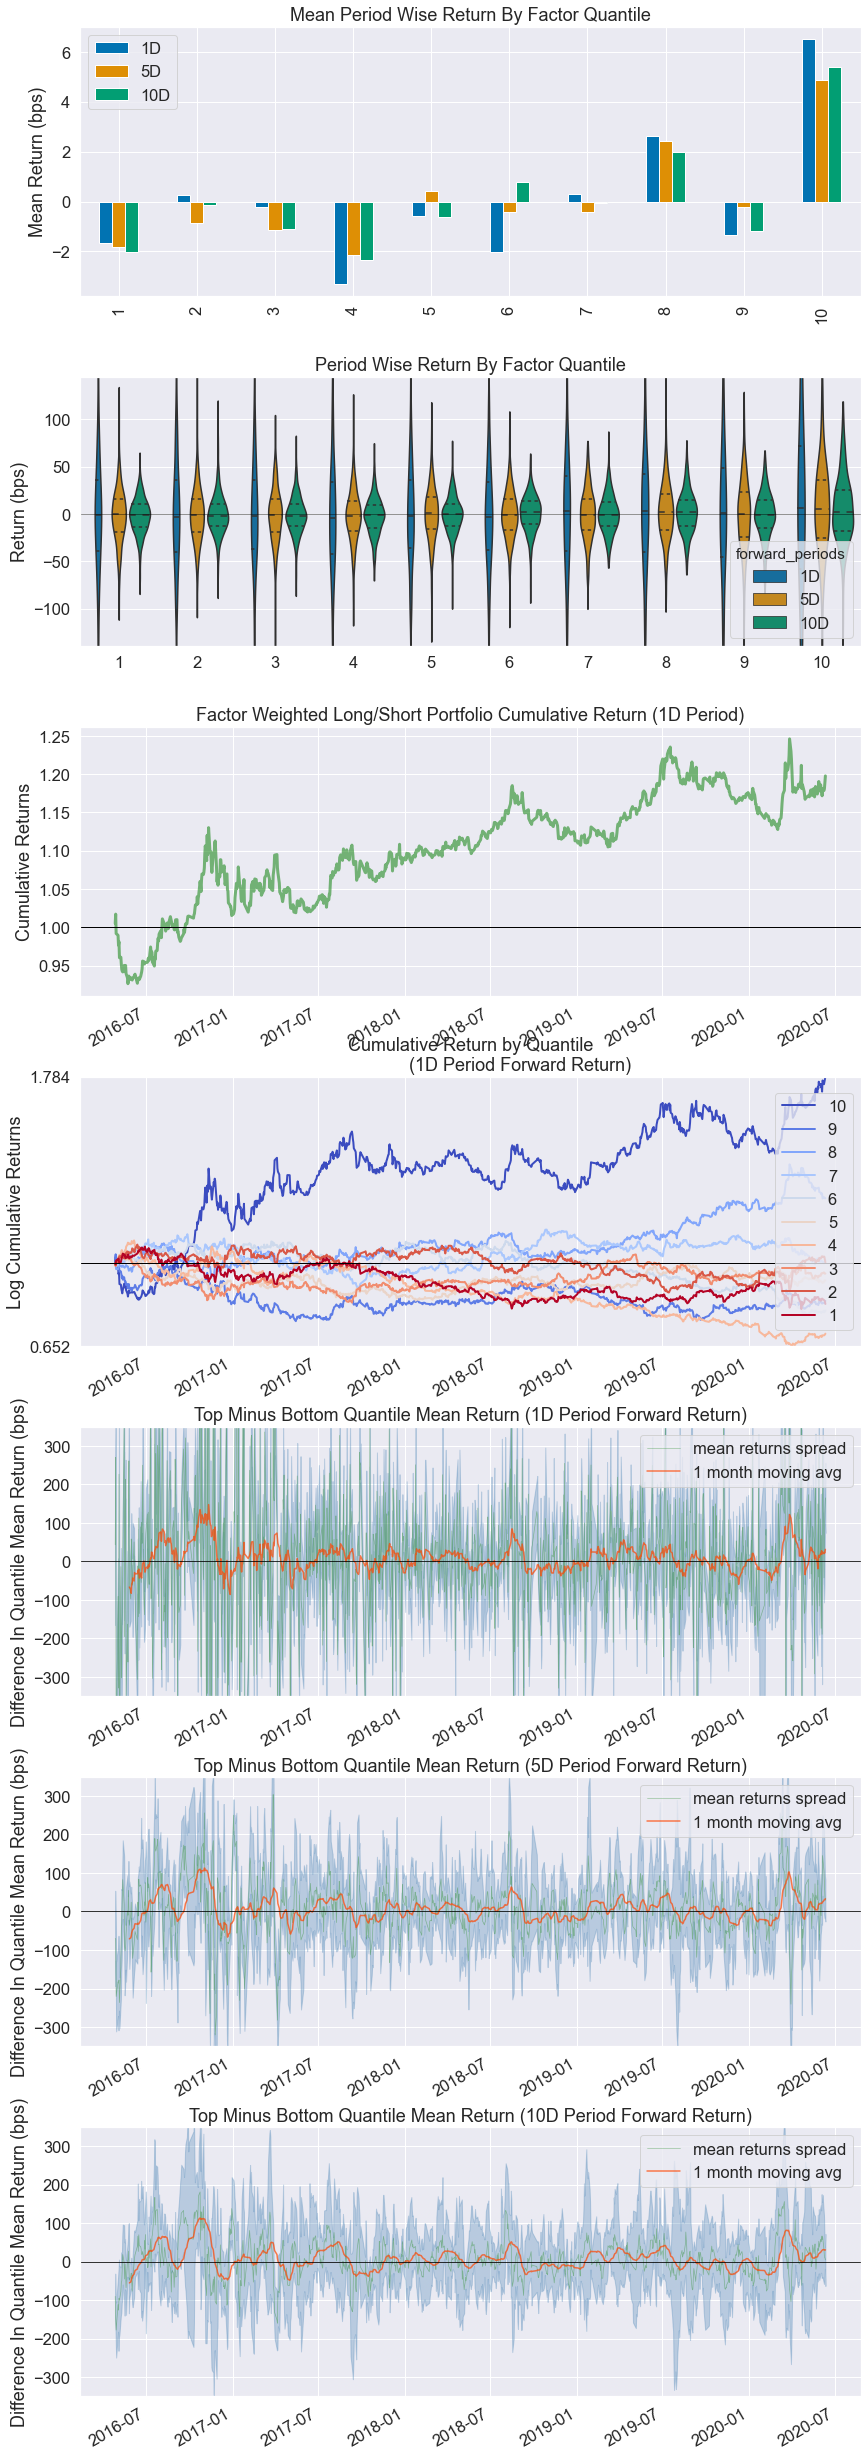

Information Analysis


,1D,5D,10D
IC Mean,0.013,0.021,0.023
IC Std.,0.303,0.289,0.268
Risk-Adjusted IC,0.043,0.072,0.087
t-stat(IC),1.361,2.291,2.766
p-value(IC),0.174,0.022,0.006
IC Skew,-0.116,-0.189,-0.292
IC Kurtosis,-0.401,-0.330,-0.125


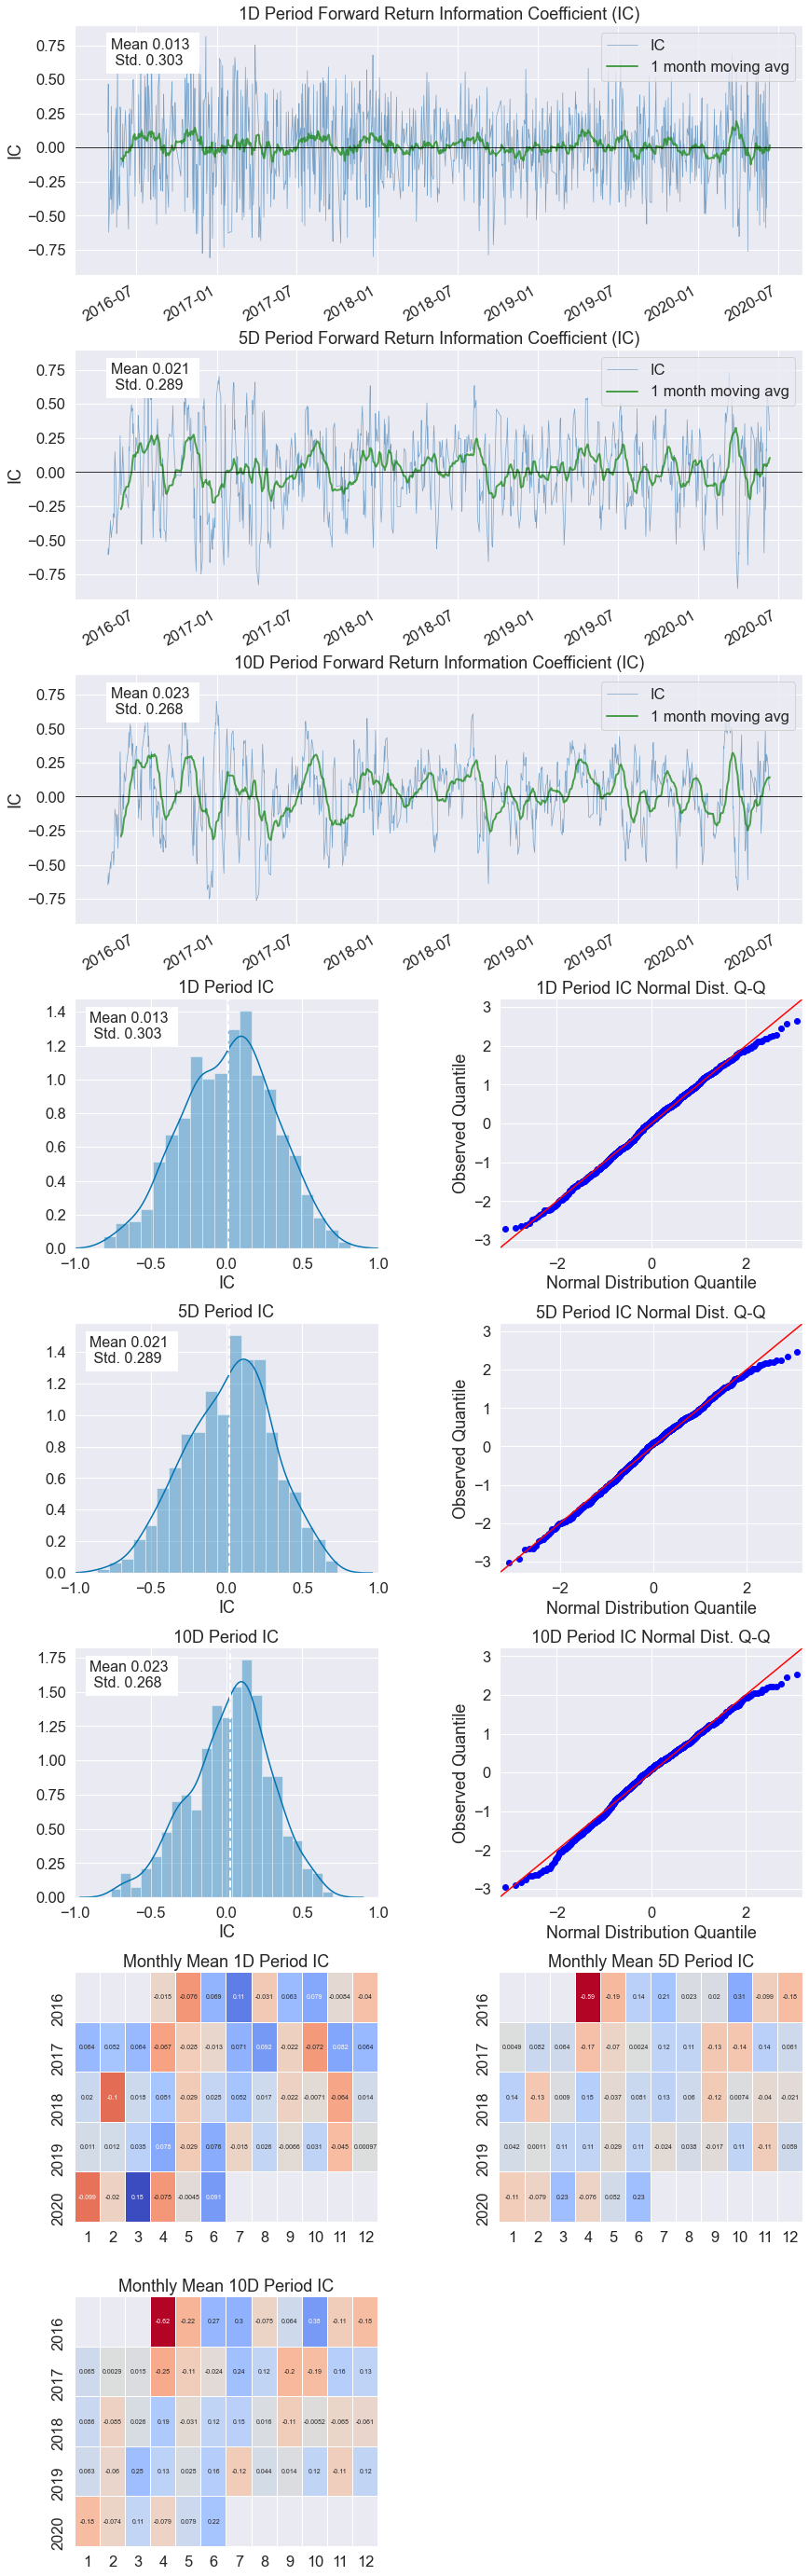

AttributeError: 'Index' object has no attribute 'get_values'

In [11]:
al.tears.create_information_tear_sheet(factor_data)
al.tears.create_full_tear_sheet(factor_data)
#al.tears.create_returns_tear_sheet(factor_data, long_short=True, group_neutral=False, by_group=False)